In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
import shap
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import randint, uniform, loguniform
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
import seaborn as sns

In [1]:
import shap

In [5]:
# === 读入数据 ===
path = "labels_noprovin0911.csv"
df = pd.read_csv(path)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Citycode  278 non-null    int64
 1   cluster   278 non-null    int64
dtypes: int64(2)
memory usage: 4.5 KB


In [7]:
# 去除新疆\西藏\青海
to_remove = [150600, 220400, 230400, 230500, 421100, 460100, 520500, 520600, 620200]

# 如果 Citycode 是浮点且都是 .0，转成 int 更稳妥（可选）
df2 = df.copy()
if df2['Citycode'].dtype.kind == 'f':
    # 仅当确实是整数编码（没有小数部分）才转
    if ((df2['Citycode'] % 1) == 0).all():
        df2['Citycode'] = df2['Citycode'].astype(int)

out_labels = df2[~df2['Citycode'].isin(to_remove)].reset_index(drop=True)

print("删除后的城市数量:", out_labels.shape[0])

删除后的城市数量: 278


In [8]:
out_labels

,Citycode,cluster
0,110000,0
1,120000,1
2,130100,2
3,130200,2
4,130300,2
...,...,...
273,640300,2
274,640400,0
275,640500,2
276,650100,2


In [9]:
# 依次读取
df2006 = pd.read_csv("All_indi_2006.csv")
df2010 = pd.read_csv("All_indi_2010.csv")
df2014 = pd.read_csv("All_indi_2014.csv")
df2018 = pd.read_csv("All_indi_2018.csv")
df2022 = pd.read_csv("All_indi_2022.csv")

# 合并成一个大表
df_all = pd.concat([df2006, df2010, df2014, df2018, df2022], ignore_index=True)

In [10]:
# 依次读取三个表加入气候指标
lst = pd.read_csv("LST_06_22.csv")
pre = pd.read_csv("Pre_06_22.csv")
tem = pd.read_csv("Tem_06_22.csv")

# 确认要保留的字段，只保留 Citycode, Year 和目标列
lst = lst[['Citycode', 'Year', 'LST_mean']]
pre = pre[['Citycode', 'Year', 'Pre_mean']]
tem = tem[['Citycode', 'Year', 'Tem_mean']]

# 逐步合并到 df_all
df_all = df_all.merge(lst, on=['Citycode', 'Year'], how='left')
df_all = df_all.merge(pre, on=['Citycode', 'Year'], how='left')
df_all = df_all.merge(tem, on=['Citycode', 'Year'], how='left')

In [11]:
# === Step 1: 读取并合并 5 个 CSV ===
files = {
    "land_use_intensity_by_city2006.csv": 2006,
    "land_use_intensity_by_city2010.csv": 2010,
    "land_use_intensity_by_city2014.csv": 2014,
    "land_use_intensity_by_city2018.csv": 2018,
    "land_use_intensity_by_city2022.csv": 2022
}

dfs = []
for f, year in files.items():
    df = pd.read_csv(f, encoding="gbk")  # 指定中文编码
    df["Year"] = year  # 新增年份列
    dfs.append(df)

# 合并成长表
lul_long = pd.concat(dfs, ignore_index=True)

# 只保留需要的列
lul_long = lul_long[["Citycode", "Year", "LUL"]]
df_all = pd.merge(df_all, lul_long, on=["Citycode", "Year"], how="left")

In [12]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1390 entries, 0 to 1389
Data columns (total 28 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   UrbanPopulation                                           1390 non-null   float64
 1   Surface_Area_of_Built_District                            1390 non-null   float64
 2   Road_Surface_Area_Per_Capita_m2                           1390 non-null   float64
 3   Parkland_per_capita                                       1390 non-null   float64
 4   Rate_of_non_hazardous_treatment_of_domestic_waste(%)      1390 non-null   float64
 5   Population_urbanization                                   1390 non-null   float64
 6   GDP                                                       1390 non-null   int64  
 7   First_sector_of_GDP                                       1390 non-null   float64
 8   Industrial_wastewa

In [13]:
# 1) 选择参与解释的“原始逐年指标列”
exclude_cols = {'Citycode','Year','D2','cluster','Surface_Area_of_Built_District','Area_of_administrative_districts','UrbanPopulation','Road_Surface_Area_Per_Capita_m2'}
all_cols = [c for c in df_all.columns if c not in exclude_cols and pd.api.types.is_numeric_dtype(df_all[c])]
raw_vars = all_cols                      # 所有数值型指标
print("逐年指标数量:", len(raw_vars))

逐年指标数量: 22


In [14]:
raw_vars

['Parkland_per_capita',
 'Rate_of_non_hazardous_treatment_of_domestic_waste(%)',
 'Population_urbanization',
 'GDP',
 'First_sector_of_GDP',
 'Industrial_wastewater_discharge_(tonnes)',
 'Industrial_fume_emissions_(tonnes)',
 'Comprehensive_industrial_solid_waste_utilisation_rate(%)',
 'Greening_coverage_in_builtup_areas',
 'CO2',
 'ISA',
 'NPP',
 'NTL',
 'PD',
 'pm2.5',
 'Science_expend',
 'SO2_REMOVE',
 'Sewage',
 'LST_mean',
 'Pre_mean',
 'Tem_mean',
 'LUL']

In [ ]:
# 4) 把逐年指标 -> 城市特征（水平/趋势/波动等）

In [15]:
years = np.sort(df_all['Year'].unique())
t = years.astype(float).reshape(-1,1)    # 用于 OLS 斜率

In [16]:
def features_from_series(y):
    y = np.asarray(y, dtype='float64')
    # 基本量
    first, last = y[0], y[-1]
    mu = np.nanmean(y)
    # 斜率（OLS 对 Year 回归）
    lr = LinearRegression().fit(t, y)
    slope = lr.coef_[0]
    # 一阶/二阶差分波动
    dy = np.diff(y)
    ddy = np.diff(y, 2) if len(y) >= 3 else np.array([0.0])
    vol1 = np.nanstd(dy) if len(dy)>0 else 0.0
    curv = np.nanmean(ddy) if len(ddy)>0 else 0.0
    # 变幅
    rng = np.nanmax(y) - np.nanmin(y)
    # 阈值跨越（示例：对于比例类变量用 0.5；按实际需要改）
    cross = 1 if np.any((y[:-1] < 0.5) & (y[1:] >= 0.5)) else 0
    return first, last, mu, slope, vol1, curv, rng, cross

In [17]:
def build_city_features(df):
    recs = []
    for cid, g in df.groupby('Citycode'):
        row = {'Citycode': cid}
        for v in raw_vars:
            y = g[v].values
            f1, fN, mu, slope, vol1, curv, rng, cross = features_from_series(y)
            row[f'{v}_first']  = f1
            row[f'{v}_last']   = fN
            row[f'{v}_mean']   = mu
            row[f'{v}_slope']  = slope
            row[f'{v}_vol1']   = vol1
            row[f'{v}_curv2']  = curv
            row[f'{v}_range']  = rng
            row[f'{v}_cross05']= cross
        recs.append(row)
    return pd.DataFrame(recs)

In [18]:
X_city = build_city_features(df_all)

In [19]:
X_city

,Citycode,Parkland_per_capita_first,Parkland_per_capita_last,Parkland_per_capita_mean,Parkland_per_capita_slope,Parkland_per_capita_vol1,Parkland_per_capita_curv2,Parkland_per_capita_range,Parkland_per_capita_cross05,Rate_of_non_hazardous_treatment_of_domestic_waste(%)_first,...,Tem_mean_range,Tem_mean_cross05,LUL_first,LUL_last,LUL_mean,LUL_slope,LUL_vol1,LUL_curv2,LUL_range,LUL_cross05
0,110000,10.68,16.63,14.166,0.42300,1.834630,-0.090000,5.95,0,74.57,...,1.179884,0,264.527306,268.575017,266.921776,0.252800,0.511078,-0.281424,4.047711,0
1,120000,6.59,9.98,8.848,0.19000,0.845470,-0.456667,3.39,0,85.06,...,1.264724,0,297.691218,323.775440,307.853927,1.461648,4.938212,3.364711,26.084222,0
2,130100,8.24,14.59,13.780,0.36650,2.861969,-2.636667,8.11,0,100.00,...,0.867959,0,283.814306,291.100760,287.655718,0.464488,0.362723,-0.131880,7.286454,0
3,130200,8.95,16.69,14.278,0.39725,2.487574,-1.676667,7.74,0,98.90,...,1.343813,0,293.597938,311.211194,300.085852,0.996368,3.443921,2.581220,17.613257,0
4,130300,8.29,17.25,16.748,0.39775,5.516833,-4.083333,12.12,0,100.00,...,1.503917,0,264.204125,267.822668,265.735264,0.246320,0.619906,0.383539,3.692445,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,640300,7.74,32.21,20.968,1.34275,3.901944,-1.066667,24.47,0,76.77,...,0.516934,0,210.387268,213.262429,212.999175,0.175463,1.725141,-1.507010,4.332190,0
274,640400,9.26,32.10,16.684,1.56775,7.444263,2.430000,24.11,0,95.80,...,0.615043,0,240.457458,232.605304,238.583953,-0.570091,4.579022,-3.135111,12.178405,0
275,640500,22.67,23.68,20.438,0.36350,7.247660,3.530000,12.52,0,96.70,...,0.478596,0,204.353408,207.871637,207.812537,0.266519,2.658322,-2.179309,6.840225,0
276,650100,5.46,13.17,9.876,0.51825,0.992380,-0.486667,7.71,0,65.39,...,1.398685,0,138.926754,130.022680,135.772809,-0.508038,2.138917,-1.666760,8.904074,0


In [20]:
# 5) 合并标签
#得到的 data 是监督学习表：每行一个城市，列是各指标的“水平/趋势/波动/曲率/变幅/阈值跨越”等特征 + cluster 作为目标。
data = X_city.merge(out_labels, on='Citycode', how='inner')
print("城市数×特征数:", data.shape)

城市数×特征数: (278, 178)


In [18]:
# 1. 特征清洗与缩放（可选：降维/去冗余）

In [21]:
# 目标变量
y = data['cluster'].astype(int).values
X = data.drop(columns=['Citycode','cluster'])

In [22]:
# 去除全零/常数列
vt = VarianceThreshold(threshold=1e-12)
X1 = pd.DataFrame(vt.fit_transform(X), columns=X.columns[vt.get_support()])

In [23]:
X1

,Parkland_per_capita_first,Parkland_per_capita_last,Parkland_per_capita_mean,Parkland_per_capita_slope,Parkland_per_capita_vol1,Parkland_per_capita_curv2,Parkland_per_capita_range,Rate_of_non_hazardous_treatment_of_domestic_waste(%)_first,Rate_of_non_hazardous_treatment_of_domestic_waste(%)_last,Rate_of_non_hazardous_treatment_of_domestic_waste(%)_mean,...,Tem_mean_curv2,Tem_mean_range,Tem_mean_cross05,LUL_first,LUL_last,LUL_mean,LUL_slope,LUL_vol1,LUL_curv2,LUL_range
0,10.68,16.63,14.166,0.42300,1.834630,-0.090000,5.95,74.57,100.0,94.210,...,0.320314,1.179884,0.0,264.527306,268.575017,266.921776,0.252800,0.511078,-0.281424,4.047711
1,6.59,9.98,8.848,0.19000,0.845470,-0.456667,3.39,85.06,100.0,95.932,...,0.284561,1.264724,0.0,297.691218,323.775440,307.853927,1.461648,4.938212,3.364711,26.084222
2,8.24,14.59,13.780,0.36650,2.861969,-2.636667,8.11,100.00,100.0,94.396,...,0.278491,0.867959,0.0,283.814306,291.100760,287.655718,0.464488,0.362723,-0.131880,7.286454
3,8.95,16.69,14.278,0.39725,2.487574,-1.676667,7.74,98.90,100.0,99.780,...,0.301012,1.343813,0.0,293.597938,311.211194,300.085852,0.996368,3.443921,2.581220,17.613257
4,8.29,17.25,16.748,0.39775,5.516833,-4.083333,12.12,100.00,100.0,111.588,...,0.344095,1.503917,0.0,264.204125,267.822668,265.735264,0.246320,0.619906,0.383539,3.692445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,7.74,32.21,20.968,1.34275,3.901944,-1.066667,24.47,76.77,100.0,94.638,...,0.312977,0.516934,0.0,210.387268,213.262429,212.999175,0.175463,1.725141,-1.507010,4.332190
274,9.26,32.10,16.684,1.56775,7.444263,2.430000,24.11,95.80,100.0,95.314,...,0.315623,0.615043,0.0,240.457458,232.605304,238.583953,-0.570091,4.579022,-3.135111,12.178405
275,22.67,23.68,20.438,0.36350,7.247660,3.530000,12.52,96.70,100.0,87.046,...,0.273566,0.478596,0.0,204.353408,207.871637,207.812537,0.266519,2.658322,-2.179309,6.840225
276,5.46,13.17,9.876,0.51825,0.992380,-0.486667,7.71,65.39,100.0,89.036,...,0.720851,1.398685,0.0,138.926754,130.022680,135.772809,-0.508038,2.138917,-1.666760,8.904074


In [24]:
# （可选）简单去冗余：相关性>0.95 的保留一个
corr = X1.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
X2 = X1.drop(columns=to_drop)
print("去冗余后特征数:", X2.shape[1])

去冗余后特征数: 130


In [23]:
#2. 训练一个可解释分类器（XGBoost 或后备 GBDT）并做交叉验证

In [25]:
try:
    from xgboost import XGBClassifier
    clf = XGBClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42
    )
    use_xgb = True
except Exception as e:
    print("XGBoost 不可用，改用 HistGradientBoostingClassifier。", e)
    from sklearn.ensemble import HistGradientBoostingClassifier
    clf = HistGradientBoostingClassifier(
        max_depth=6, learning_rate=0.06, l2_regularization=1.0, random_state=42
    )
    use_xgb = False

In [26]:
pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # 稀疏下稳妥；若 dense 可用 with_mean=True
    ('clf', clf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc = cross_val_score(pipe, X2, y, cv=cv, scoring='accuracy').mean()
f1m = cross_val_score(pipe, X2, y, cv=cv, scoring='f1_macro').mean()
print(f"5折CV: Acc={acc:.3f}, F1_macro={f1m:.3f}")

# 在全量数据上拟合一个终版模型（供 SHAP 使用）
pipe.fit(X2, y)

5折CV: Acc=0.784, F1_macro=0.646


Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [27]:
# 在跑 SHAP 和画图之前就做一次“冻结”，后续都用这个名字
y_labels = np.asarray(y)        # y 是你原来的聚类标签

In [27]:
# 寻找最佳参数

In [26]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 多分类下“多数类”会压制少数类，用样本权重平衡一下
sample_weight = compute_sample_weight(class_weight='balanced', y=y)

In [27]:
# 强烈建议：让 XGB 用 hist 分裂法，速度快
pipe.set_params(clf__tree_method='hist')

param_distributions_xgb = {
    'clf__n_estimators': randint(300, 1200),
    'clf__max_depth':    randint(3, 6),                # 3–5最常用
    'clf__learning_rate': loguniform(1e-2, 2e-1),      # 0.01–0.2
    'clf__min_child_weight': randint(1, 6),
    'clf__subsample':    uniform(0.6, 0.4),            # 0.6–1.0
    'clf__colsample_bytree': uniform(0.6, 0.4),        # 0.6–1.0
    'clf__gamma':        uniform(0.0, 2.0),            # 或改 loguniform(1e-8, 2)
    'clf__reg_alpha':    loguniform(1e-8, 1e-1),       # L1
    'clf__reg_lambda':   loguniform(1e-2, 10.0)        # L2
}

In [28]:
param_distributions_hgb = {
    'clf__max_iter':        randint(300, 1000),
    'clf__learning_rate':   loguniform(1e-2, 2e-1),
    'clf__max_depth':       randint(3, 12),            # 或者用 None
    'clf__max_leaf_nodes':  randint(15, 63),
    'clf__min_samples_leaf': randint(5, 50),
    'clf__l2_regularization': loguniform(1e-4, 10.0),
    'clf__early_stopping':  [True],
    'clf__validation_fraction': [0.1, 0.15]
    # 注：部分 sklearn 版本暂不支持 class_weight，请以本机版本为准
}

In [29]:
if use_xgb:
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions_xgb,
        n_iter=40,                 # 可加大到 80 提升稳定性
        scoring='f1_macro',
        cv=cv,
        n_jobs=-1,
        verbose=1,
        random_state=42,
        refit=True                 # 最优参数在全量数据上重拟合
    )
    search.fit(X2, y, clf__sample_weight=sample_weight)
else:
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions_hgb,
        n_iter=40,
        scoring='f1_macro',
        cv=cv,
        n_jobs=-1,
        verbose=1,
        random_state=42,
        refit=True
    )
    # HGBClassifier 是否支持 sample_weight 取决于版本；若报错就删掉这个 fit 参数
    try:
        search.fit(X2, y, clf__sample_weight=sample_weight)
    except TypeError:
        search.fit(X2, y)

print("Best CV f1_macro:", search.best_score_)
print("Best params:")
for k, v in search.best_params_.items():
    print("  ", k, "=", v)

best_pipe = search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best CV f1_macro: 0.7162905636509962
Best params:
   clf__colsample_bytree = 0.6643232205669994
   clf__gamma = 1.0974675787331722
   clf__learning_rate = 0.0794650948407619
   clf__max_depth = 3
   clf__min_child_weight = 1
   clf__n_estimators = 460
   clf__reg_alpha = 1.3382200896297046e-08
   clf__reg_lambda = 0.30316645506200035
   clf__subsample = 0.6715290836885315


In [30]:
acc = cross_val_score(best_pipe, X2, y, cv=cv, scoring='accuracy').mean()
f1m = cross_val_score(best_pipe, X2, y, cv=cv, scoring='f1_macro').mean()
print(f"Tuned 5-fold: Acc={acc:.3f}, F1_macro={f1m:.3f}")

# 拟合全量，后面直接拿 best_pipe 做 SHAP
best_pipe.fit(X2, y)

Tuned 5-fold: Acc=0.773, F1_macro=0.614


Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6643232205669994, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=1.0974675787331722,
                               grow_policy=No...ortance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.0794650948407619, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=460, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

# 用完全相同的折进行配对对比

In [31]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_pipe, f1_pipe, acc_best, f1_best = [], [], [], []
for tr, te in cv.split(X2, y):
    # pipe
    pipe.fit(X2.iloc[tr], y[tr])
    p1 = pipe.predict(X2.iloc[te])
    acc_pipe.append(accuracy_score(y[te], p1))
    f1_pipe.append(f1_score(y[te], p1, average='macro'))

    # best_pipe
    best_pipe.fit(X2.iloc[tr], y[tr])
    p2 = best_pipe.predict(X2.iloc[te])
    acc_best.append(accuracy_score(y[te], p2))
    f1_best.append(f1_score(y[te], p2, average='macro'))

print("pipe   Acc:", np.mean(acc_pipe), "F1m:", np.mean(f1_pipe))
print("best   Acc:", np.mean(acc_best), "F1m:", np.mean(f1_best))
print("per-fold F1m diff (pipe - best):", np.round(np.array(f1_pipe)-np.array(f1_best), 4))

pipe   Acc: 0.7840259740259741 F1m: 0.6456777514716626
best   Acc: 0.7732467532467533 F1m: 0.6139176396468903
per-fold F1m diff (pipe - best): [-0.0144  0.115   0.014   0.0442  0.    ]


In [ ]:
# SHAP 全局 + 局部解释

In [28]:
# === A2. 仅 transform，不要再 fit_transform（避免与模型不一致）===
Xt = pipe.named_steps['scaler'].transform(X2)
# === B1. 构建 Explainer（树模型优先 TreeExplainer，更稳定）===
if use_xgb:
    explainer = shap.TreeExplainer(pipe.named_steps['clf'])
    shap_values = explainer.shap_values(Xt)   # list(K) of (n, p)，或 (n, p, K)
else:
    # KernelExplainer 随机性大，若必须用，请固定随机种子并增大 nsamples
    rng = np.random.RandomState(42)
    bg_idx = rng.choice(Xt.shape[0], size=min(200, Xt.shape[0]), replace=False)
    explainer = shap.KernelExplainer(pipe.named_steps['clf'].predict_proba, Xt[bg_idx])
    shap_values = explainer.shap_values(Xt, nsamples=1000)  # 提高采样以稳定

# === B2. 统一形状为 (n_samples, n_features, n_classes) ===
if isinstance(shap_values, list):
    shap_arr = np.stack(shap_values, axis=-1)        # (n, p, K)
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    shap_arr = shap_values                            # (n, p, K)
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 2:
    shap_arr = shap_values[..., np.newaxis]           # (n, p, 1)
else:
    raise ValueError("未知的 shap_values 形状")

# === B3. 一致性断言（防止后面所有步骤对不上）===
n, p = X2.shape
assert shap_arr.shape[0] == n, "n_samples 不一致"
assert shap_arr.shape[1] == p, "n_features 不一致（可能误改了 X2.columns / 映射）"

# === B4. 计算“带后缀特征”的全局 |SHAP|（将来还要做单城/簇解释）===
shap_abs = np.abs(shap_arr).mean(axis=(0, 2))         # (p,)
global_importance_raw = pd.Series(shap_abs, index=X2.columns) \
                           .sort_values(ascending=False)
print("全局 Top-20（带后缀）:\n", global_importance_raw.head(20))

全局 Top-20（带后缀）:
 Rate_of_non_hazardous_treatment_of_domestic_waste(%)_first       0.400913
Rate_of_non_hazardous_treatment_of_domestic_waste(%)_curv2       0.270812
SO2_REMOVE_first                                                 0.257763
Tem_mean_first                                                   0.239835
First_sector_of_GDP_slope                                        0.210892
Comprehensive_industrial_solid_waste_utilisation_rate(%)_vol1    0.164421
Science_expend_curv2                                             0.159911
Pre_mean_first                                                   0.147808
Science_expend_last                                              0.139168
Comprehensive_industrial_solid_waste_utilisation_rate(%)_mean    0.136430
Comprehensive_industrial_solid_waste_utilisation_rate(%)_last    0.121926
LST_mean_curv2                                                   0.116246
SO2_REMOVE_last                                                  0.106245
SO2_REMOVE_vol1      

# 全局贡献分析——作图

In [29]:
# === C1. 定义 “原指标 → 七大类” 映射（你给的 cat_map）===
cat_map = {
    "Resistance": [
        "Industrial_wastewater_discharge_(tonnes)",
        "Industrial_fume_emissions_(tonnes)",
        "CO2", "pm2.5"
    ],
    "Adaptation": [
        "Rate_of_non_hazardous_treatment_of_domestic_waste(%)",
        "Comprehensive_industrial_solid_waste_utilisation_rate(%)",
        "SO2_REMOVE", "Sewage"
    ],
    "Recovery": [
        "Parkland_per_capita", "Greening_coverage_in_builtup_areas",
        "NPP", "Science_expend"
    ],
    "Population urbanization": [
        "Population_urbanization", "PD", "UrbanPopulation"
    ],
    "Land urbanization": [
        "ISA", "LUL", "Road_Surface_Area_Per_Capita_m2", "Surface_Area_of_Built_District"
    ],
    "Economic urbanization": [
        "GDP", "First_sector_of_GDP", "NTL"
    ],
    "Climate indicator": [
        "LST_mean", "Pre_mean", "Tem_mean"
    ],
}

# === A. 论文简称映射（基名 -> 简称）===
abbr_map = {
    "Parkland_per_capita": "PPC",
    "Rate_of_non_hazardous_treatment_of_domestic_waste(%)": "DWHR",
    "Population_urbanization": "PUR",
    "GDP": "GDP",
    "First_sector_of_GDP": "GDP1",
    "Industrial_wastewater_discharge_(tonnes)": "IWD",
    "Industrial_fume_emissions_(tonnes)": "IFE",
    "Comprehensive_industrial_solid_waste_utilisation_rate(%)": "ISUR",
    "Greening_coverage_in_builtup_areas": "GCR",
    "CO2": "CO2",
    "ISA": "ISA",
    "NPP": "NPP",
    "NTL": "NTL",
    "PD": "PD",
    "pm2.5": "PM25",
    "Science_expend": "STE",
    "SO2_REMOVE": "SO2R",
    "Sewage": "SEWD",
    "LST_mean": "LST",
    "Pre_mean": "PRE",
    "Tem_mean": "TMP",
    "LUL": "LUI",
}
base2cat = {b:cat for cat, bases in cat_map.items() for b in bases}
all_bases = sorted(base2cat.keys(), key=len, reverse=True)

def get_base(feat_name: str):
    for b in all_bases:
        if feat_name == b or feat_name.startswith(b + "_"):
            return b
    return None


# === B. 把“基名 + 后缀”重命名为 “简称 + 后缀”（仅用于显示）===
def abbr_with_suffix(feat_name: str) -> str:
    base = get_base(feat_name)
    if base is None:
        return feat_name  # 找不到映射就原样返回
    # 提取后缀（例：xxx_slope / xxx_first / xxx_curv2 ...）
    suf = feat_name[len(base):]  # 去掉前缀 base 后剩下的就是 "_slope" 之类
    short = abbr_map.get(base, base)  # 找简称；没有就保留原名
    return short + suf

# === C. 仅基名重命名为简称（用于“按基名聚合”的全局柱状图）===
def abbr_base_only(base_name: str) -> str:
    return abbr_map.get(base_name, base_name)


# === C2. 用“带后缀的全局 SHAP（global_importance_raw）”做聚合副本 ===
feat_to_base = global_importance_raw.index.to_series().map(get_base)
imp_by_var   = global_importance_raw.groupby(feat_to_base).sum() \
                                    .drop(index=[None], errors='ignore') \
                                    .sort_values(ascending=False)
var_to_cat   = pd.Series(imp_by_var.index.map(lambda b: base2cat.get(b, "Other")),
                         index=imp_by_var.index)
imp_by_cat   = imp_by_var.groupby(var_to_cat).sum().sort_values(ascending=False)

/tmp/ipykernel_27069/4072504651.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


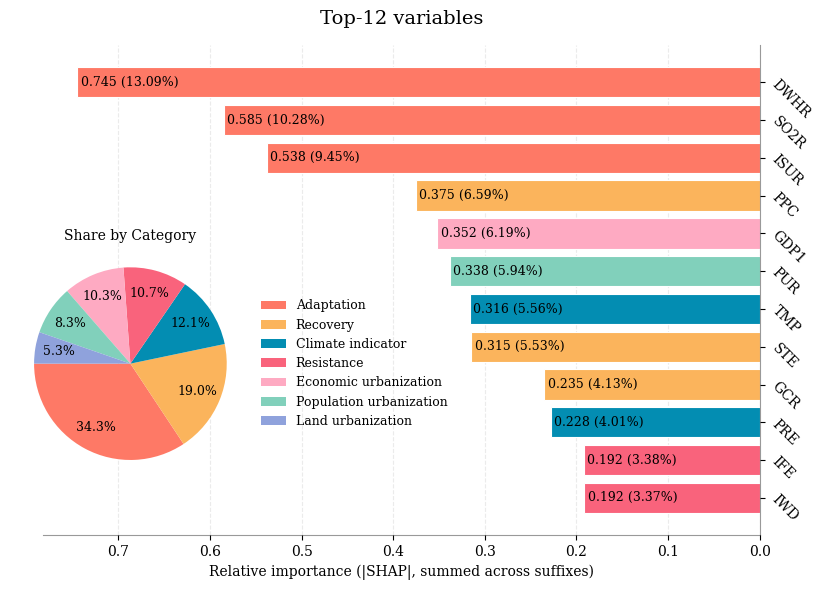

In [32]:
# 设置字体
plt.rcParams["font.family"] = "DejaVu Serif"

top_n = 12
title_vars = f"Top-{top_n} variables"
title_pie  = "Share by Category"

cat_colors = {
    "Resistance":             "#F9637C",
    "Adaptation":             "#FE7966",
    "Recovery":               "#FBB45C",
    "Population urbanization":"#81D0BB",
    "Land urbanization":      "#8FA2DC",
    "Economic urbanization":  "#FEAAC2",
    "Climate indicator":      "#038DB2",
    "Other":                  "#E5E1E0"
}

# 只供画图使用的局部变量
imp_by_var_plot = imp_by_var.copy()
imp_by_cat_plot = imp_by_cat.copy()
var_to_cat_plot = var_to_cat.copy()

top_var = imp_by_var.head(top_n)[::-1]
top_var_labels = [abbr_base_only(b) for b in top_var.index]  # 用简称作为 y 轴标签
total_sum = imp_by_var_plot.sum()
pct_var   = (top_var / total_sum) * 100.0

top_var_cats   = var_to_cat_plot.loc[top_var.index].fillna("Other")
top_var_colors = [cat_colors.get(c, cat_colors["Other"]) for c in top_var_cats]

fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(111)

bars = ax.barh(top_var_labels, top_var.values,
               color=top_var_colors, edgecolor="white", linewidth=0.8)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.xaxis.grid(True, which="major", linestyle="--", alpha=0.25)
ax.set_axisbelow(True)

ax.set_xlabel("Relative importance (|SHAP|, summed across suffixes)")
# 主标题居中放上方
ax.set_title(title_vars, pad=15, loc="center", fontsize=14)

# 设置纵坐标标签倾斜（右侧，从左上往右下）
ax.set_yticks(range(len(top_var_labels)))
ax.set_yticklabels(top_var_labels, rotation=-45, ha="left", fontsize=10)

ax.invert_xaxis()

xmax = top_var.values.max()
for rect, val, pct in zip(bars, top_var.values, pct_var.values):
    x = val + -0.005 * xmax
    y_pos = rect.get_y() + rect.get_height()/2
    ax.text(x, y_pos, f"{val:.3f} ({pct:.2f}%)",
            va="center", ha="left", fontsize=9)

for spine in ["top", "left"]:
    ax.spines[spine].set_visible(False)
ax.spines["right"].set_alpha(0.4)
ax.spines["bottom"].set_alpha(0.4)

inset = inset_axes(ax, width="120%", height="150%",
                   bbox_to_anchor=(0.01, 0.2, 0.28, 0.6),
                   bbox_transform=ax.transAxes, borderpad=0)

pie_labels = imp_by_cat_plot.index
pie_vals   = imp_by_cat_plot.values
pie_colors = [cat_colors.get(c, cat_colors["Other"]) for c in pie_labels]

wedges, texts, autotexts = inset.pie(
    pie_vals, labels=None, colors=pie_colors,
    autopct=lambda p: f"{p:.1f}%", textprops={'fontsize': 9},
    startangle=180, pctdistance=0.75
)
inset.set_title(title_pie, fontsize=10, pad=0.1)
inset.legend(wedges, pie_labels, title=None,
             loc="center left", bbox_to_anchor=(1.02, 0.5),
             fontsize=9, frameon=False, borderaxespad=0.)

plt.tight_layout()
plt.savefig("GlobalSHAP.png", dpi=900, bbox_inches="tight")
plt.show()

In [33]:
# 0. 断言：X2 与 y 的样本数一致
assert X2.shape[0] == len(y), f"X2行数({X2.shape[0]})与y长度({len(y)})不一致"

# 0.1 断言：shap_arr 的样本维度与 X2 一致（你前面已经有）
n, p = X2.shape
assert shap_arr.shape[0] == n, "n_samples 不一致（shap_arr vs X2）"
assert shap_arr.shape[1] == p, "n_features 不一致（shap_arr vs X2）"

# 0.2 检查 SHAP 是否本身就有 NaN（如果这里就有，后面一切都无意义）
import numpy as np
assert np.isfinite(shap_arr).all(), "shap_arr 含 NaN/Inf，请先排查 explainer 或 Xt"

In [34]:
# 1. 获取模型的类别顺序（TreeSHAP 的通道顺序也是它）
clf = pipe.named_steps['clf']
model_classes = clf.classes_                # 例如 array([0,1,2]) 或 array([1,2,3])

# 1.1 把你的 y 映射到“模型类索引”空间，确保 y_idx ∈ {0,1,...,K-1}
le = LabelEncoder().fit(model_classes)
y_idx = le.transform(y)                      # y_idx 的取值顺序和 shap_arr 的第3维一致

# 1.2 打印检查
print("model_classes:", model_classes)
print("unique(y):", np.unique(y), "→ unique(y_idx):", np.unique(y_idx))
print("每类样本数（按模型类顺序）:", np.bincount(y_idx, minlength=len(model_classes)))

model_classes: [0 1 2]
unique(y): [0 1 2] → unique(y_idx): [0 1 2]
每类样本数（按模型类顺序）: [167  27  84]


In [35]:
K = shap_arr.shape[2]  # 通道数 = 模型类别数

def cluster_profile_signed(k, topn=10):
    # 用 y_idx（已与 shap_arr 第3维对齐）筛选簇内样本
    idx = np.where(y_idx == k)[0]
    print(f"[DEBUG] Cluster {k}: 组内样本数 = {len(idx)}")
    if len(idx) == 0:
        # 空簇直接返回空结果，避免 NaN 干扰
        return pd.Series(dtype=float), pd.Series(dtype=float)

    # 对“第 k 个通道”的 SHAP 做组内均值
    prof = shap_arr[idx, :, k].mean(axis=0)     # (p,)
    s = pd.Series(prof, index=X2.columns)

    # 分别取“推向簇k”和“拉离簇k”的 Top-N
    top_pos = s.sort_values(ascending=False).head(topn)
    top_neg = s.sort_values(ascending=True ).head(topn)
    return top_pos, top_neg

for k in range(K):
    pos, neg = cluster_profile_signed(k, topn=10)
    print(f"\n[Cluster {k}] 推向簇k (top+):\n", pos)
    print(f"[Cluster {k}] 拉离簇k (top-):\n", neg)

[DEBUG] Cluster 0: 组内样本数 = 167

[Cluster 0] 推向簇k (top+):
 First_sector_of_GDP_slope                                        0.317645
Tem_mean_first                                                   0.299246
SO2_REMOVE_first                                                 0.229918
Comprehensive_industrial_solid_waste_utilisation_rate(%)_mean    0.153974
Science_expend_last                                              0.121972
First_sector_of_GDP_first                                        0.106982
Comprehensive_industrial_solid_waste_utilisation_rate(%)_last    0.106939
Pre_mean_first                                                   0.090711
Rate_of_non_hazardous_treatment_of_domestic_waste(%)_first       0.082435
SO2_REMOVE_vol1                                                  0.064166
dtype: float32
[Cluster 0] 拉离簇k (top-):
 ISA_first                                                          -0.002659
NTL_first                                                          -0.001618
Industr

In [36]:
#      y_idx: (n_samples,) 已与模型类顺序一致
feat_names = X2.columns

def contrastive_shap_suffix(k, ref='rest', t=None):
    """
    返回：Series(index=带后缀特征名, value=ΔSHAP)，ΔSHAP = 簇内均值 - 参照均值
    ref: 'rest'（簇k vs 其他簇）、'all'（簇k vs 全样本）、'pair'（簇k vs 指定簇t）
    """
    idx_k = (y_idx == k)

    if ref == 'rest':
        idx_ref = ~idx_k
    elif ref == 'all':
        idx_ref = slice(None)  # 全部
    elif ref == 'pair':
        assert t is not None and t != k
        idx_ref = (y_idx == t)
    else:
        raise ValueError("ref must be 'rest', 'all', or 'pair'.")

    S_k   = shap_arr[idx_k, :, k].mean(axis=0)       # (p,)
    S_ref = shap_arr[idx_ref, :, k].mean(axis=0)     # (p,)
    delta = S_k - S_ref
    return pd.Series(delta, index=feat_names).sort_values(ascending=False)

# 簇k相对“其他簇”的差异（最推荐）
delta_k = contrastive_shap_suffix(k=0, ref='rest')

/tmp/ipykernel_27069/33292410.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


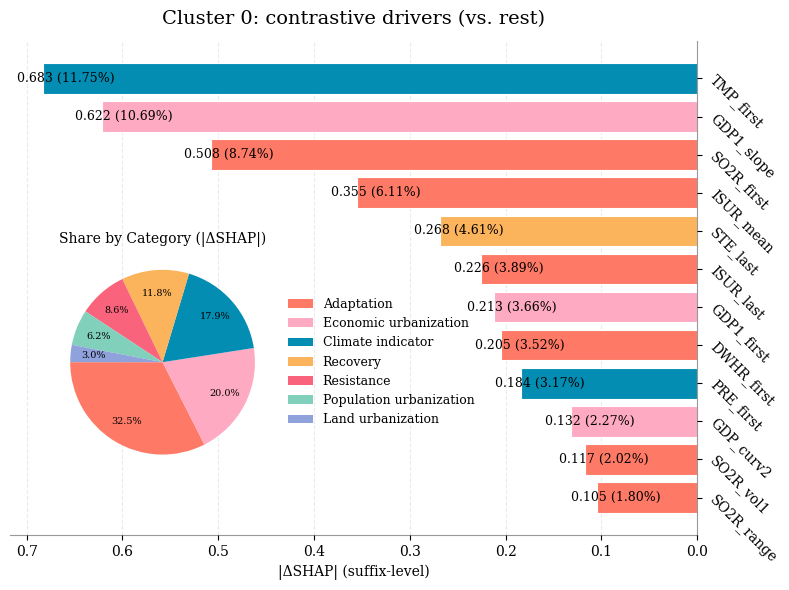

/tmp/ipykernel_27069/33292410.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


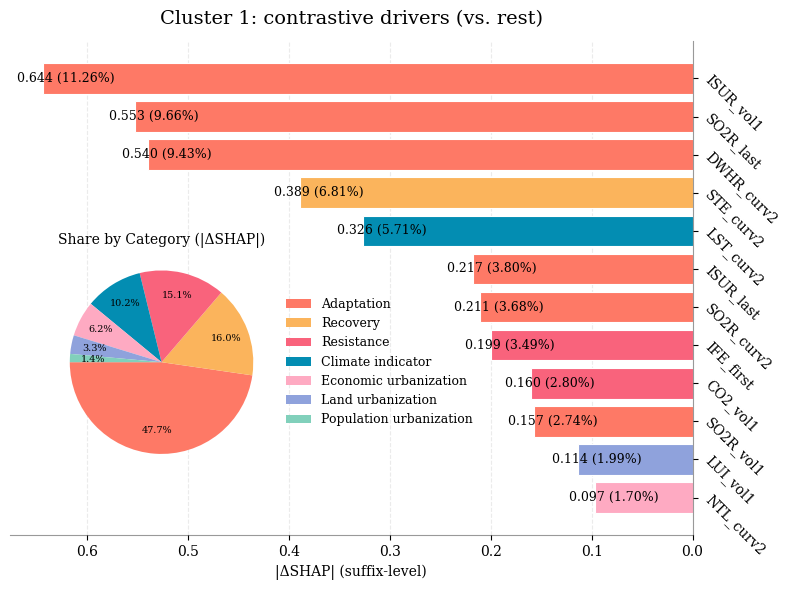

/tmp/ipykernel_27069/33292410.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


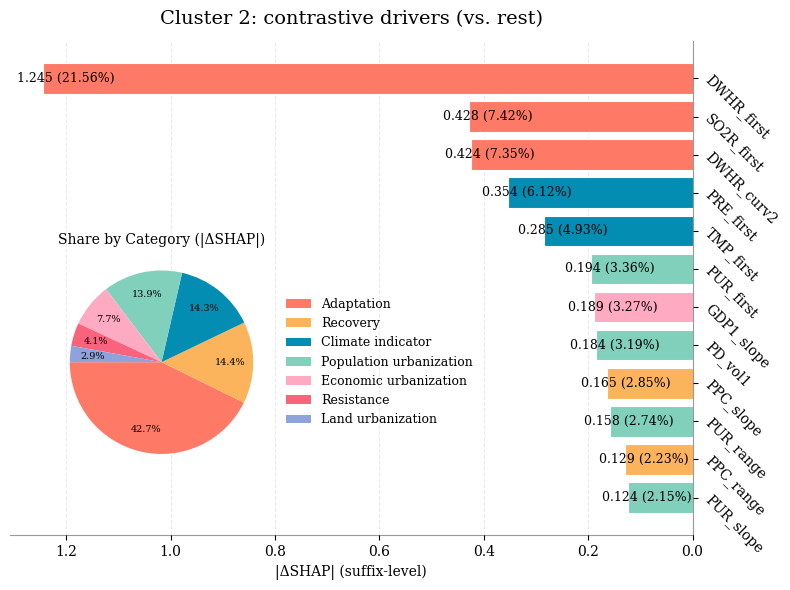

In [38]:
# 设置全局字体
plt.rcParams["font.family"] = "DejaVu Serif"

def plot_contrast_bar_pie_suffix(k, ref='rest', top_n=12, title_prefix="Cluster", use_abbr=True, save=True):
    # 1) 计算 ΔSHAP（带后缀）
    delta = contrastive_shap_suffix(k, ref=ref)         # 有正有负
    delta_abs = delta.abs().sort_values(ascending=False)
    top_var = delta_abs.head(top_n)[::-1]               # 反转便于从上往下读
    total_sum = delta_abs.sum()
    pct_var = (top_var / total_sum) * 100.0

    # === 生成“简称+后缀”的标签 ===
    if use_abbr:
        top_labels = [abbr_with_suffix(f) for f in top_var.index]
    else:
        top_labels = list(top_var.index)
        
    # 2) 类别聚合（|ΔSHAP|按“原指标→七类”）
    feat_to_base_all = delta_abs.index.to_series().map(get_base)
    var_sum = delta_abs.groupby(feat_to_base_all).sum().drop(index=[None], errors='ignore')
    var_to_cat = pd.Series(var_sum.index.map(lambda b: base2cat.get(b, "Other")), index=var_sum.index)
    cat_sum = var_sum.groupby(var_to_cat).sum().sort_values(ascending=False)

    # 3) 配色
    top_var_cats = top_var.index.to_series().map(get_base).map(lambda b: base2cat.get(b, "Other"))
    top_var_colors = [cat_colors.get(c, cat_colors["Other"]) for c in top_var_cats]

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    # barh
    bars = ax.barh(top_labels, top_var.values,
                   color=top_var_colors, edgecolor="white", linewidth=0.8)

    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.xaxis.grid(True, which="major", linestyle="--", alpha=0.25)
    ax.set_axisbelow(True)

    ax.set_xlabel("|ΔSHAP| (suffix-level)")
    # === 标题居中 ===
    ax.set_title(f"{title_prefix} {k}: contrastive drivers (vs. {ref})",
                 pad=12, loc="center", fontsize=14)

    # === y 轴标签倾斜 ===
    ax.set_yticks(range(len(top_labels)))
    ax.set_yticklabels(top_labels, rotation=-45, ha="left", fontsize=10)

    ax.invert_xaxis()

    xmax = top_var.values.max()
    for rect, val, pct in zip(bars, top_var.values, pct_var.values):
        x = val + 0.04 * xmax
        y = rect.get_y() + rect.get_height()/2
        ax.text(x, y, f"{val:.3f} ({pct:.2f}%)",
                va="center", ha="left", fontsize=9)

    for spine in ["top", "left"]:
        ax.spines[spine].set_visible(False)
    ax.spines["right"].set_alpha(0.4)
    ax.spines["bottom"].set_alpha(0.4)

    # 饼图嵌入
    inset = inset_axes(ax, width="120%", height="150%",
                       bbox_to_anchor=(0.11, 0.2, 0.28, 0.6),
                       bbox_transform=ax.transAxes, borderpad=0)

    pie_labels = cat_sum.index
    pie_vals   = cat_sum.values
    pie_colors = [cat_colors.get(c, cat_colors["Other"]) for c in pie_labels]

    wedges, texts, autotexts = inset.pie(
        pie_vals, labels=None, colors=pie_colors,
        autopct=lambda p: f"{p:.1f}%", textprops={'fontsize': 7},
        startangle=180, pctdistance=0.75
    )
    inset.set_title("Share by Category (|ΔSHAP|)", fontsize=10, pad=0.1)
    inset.legend(wedges, pie_labels, loc="center left", bbox_to_anchor=(1.02, 0.5),
                 fontsize=9, frameon=False, borderaxespad=0.)

    plt.tight_layout()

    # === 保存单张图片 ===
    if save:
        plt.savefig(f"contrast_cluster_{k}.png", dpi=300, bbox_inches="tight")
        # plt.savefig(f"contrast_cluster_{k}.pdf", bbox_inches="tight")  # 如果要矢量图

    plt.show()


# 用法：三类各画一张（vs rest），输出三张单独的文件
for k in range(shap_arr.shape[2]):
    plot_contrast_bar_pie_suffix(k, ref='rest', top_n=12, title_prefix="Cluster", save=True)

In [39]:
delta_signed = contrastive_shap_suffix(k=0, ref='rest')  # 有正有负
print("Top + (推向簇0):\n", delta_signed.sort_values(ascending=False).head(10))
print("Top - (拉离簇0):\n", delta_signed.sort_values().head(10))

Top + (推向簇0):
 Tem_mean_first                                                   0.683260
First_sector_of_GDP_slope                                        0.621761
SO2_REMOVE_first                                                 0.508088
Comprehensive_industrial_solid_waste_utilisation_rate(%)_mean    0.354972
Science_expend_last                                              0.268205
Comprehensive_industrial_solid_waste_utilisation_rate(%)_last    0.226228
First_sector_of_GDP_first                                        0.212582
Rate_of_non_hazardous_treatment_of_domestic_waste(%)_first       0.204662
Pre_mean_first                                                   0.184288
GDP_curv2                                                        0.131720
dtype: float32
Top - (拉离簇0):
 Science_expend_cross05                                              0.0
Tem_mean_cross05                                                    0.0
Greening_coverage_in_builtup_areas_cross05                          0.0

In [42]:
# 设置全局字体
plt.rcParams["font.family"] = "DejaVu Serif"

def explain_city_with_waterfall(cluster_id, citycode, topn=10, cityname=None, save=True):
    # 找到该城市
    idx = data.index[data['Citycode'] == citycode]
    if len(idx) == 0:
        print(f"Citycode {citycode} 不存在于数据中。")
        return
    i = idx[0]

    # 取该城市的 SHAP 向量 & base value
    if isinstance(shap_values, list):
        cls = y[i]
        sv = shap_values[cls][i]
        base_val = explainer.expected_value[cls]
    elif shap_arr.ndim == 3:
        cls = y[i]
        sv = shap_arr[i, :, cls]
        base_val = explainer.expected_value[cls]
    else:
        sv = shap_arr[i, :, 0]
        base_val = explainer.expected_value[0]

    # === (1) 打印前把 index 重命名为“简称+后缀” ===
    s = pd.Series(sv, index=X2.columns)
    s_top = s.sort_values(key=np.abs, ascending=False).head(topn)
    s_top.index = [abbr_with_suffix(f) for f in s_top.index]

    print(f"\n城市 {citycode} | 实际簇 = {y[i]} (输入簇 = {cluster_id})")
    print(s_top)

    # === (2) 瀑布图里也用“简称+后缀”的 feature_names ===
    display_names = [abbr_with_suffix(f) for f in X2.columns]
    exp = shap.Explanation(
        values       = sv,
        base_values  = base_val,
        data         = X2.iloc[i],        # 数值仍用原数据
        feature_names= display_names      # 只改显示名称
    )

    # 绘制瀑布图
    shap.plots.waterfall(exp, max_display=topn, show=False)

    # 添加居中标题
    if cityname is not None:
        plt.title(cityname, fontsize=14, pad=15, loc="center")

    plt.tight_layout()

    # 保存图片
    if save:
        fname = f"waterfall_{citycode}.png"
        plt.savefig(fname, dpi=300, bbox_inches="tight")
        print(f"图片已保存为 {fname}")

    plt.show()


城市 110000 | 实际簇 = 0 (输入簇 = 0)
STE_last      0.768730
TMP_first    -0.386236
GDP_curv2     0.369020
SO2R_vol1     0.247560
ISUR_mean    -0.227832
GDP1_slope   -0.219070
GDP1_first   -0.156461
PD_vol1       0.152750
NTL_slope     0.149532
NPP_range     0.139644
dtype: float32
图片已保存为 waterfall_110000.png


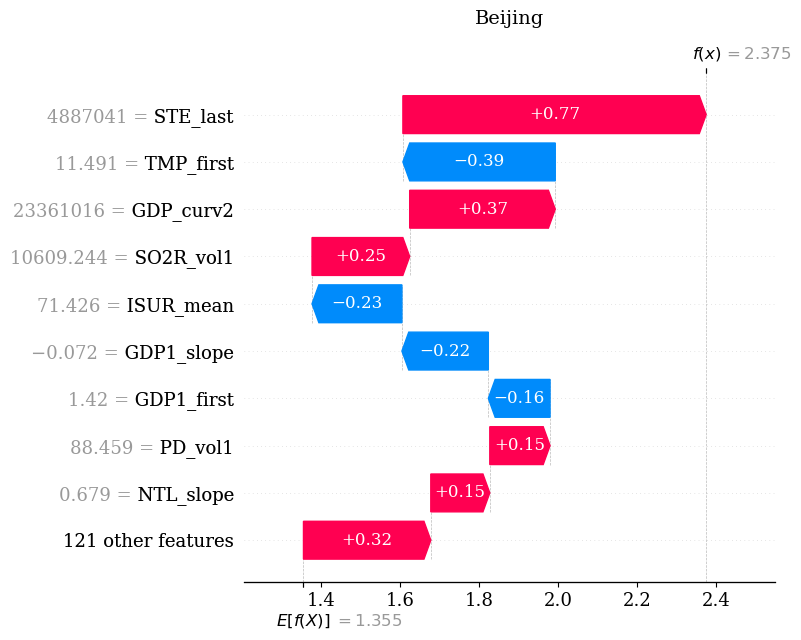

In [43]:
# 比如要看 Cluster 2 中 Citycode=130100 的 SHAP：北京
explain_city_with_waterfall(cluster_id=0, citycode=110000, topn=10, cityname="Beijing")


城市 620700 | 实际簇 = 0 (输入簇 = 0)
GDP1_slope    0.604309
GDP1_first    0.458212
TMP_first    -0.404678
SO2R_first    0.384402
DWHR_first    0.362505
IWD_first     0.179380
NPP_range    -0.164509
ISUR_last     0.161820
NTL_slope    -0.161443
IWD_mean      0.149494
dtype: float32
图片已保存为 waterfall_620700.png


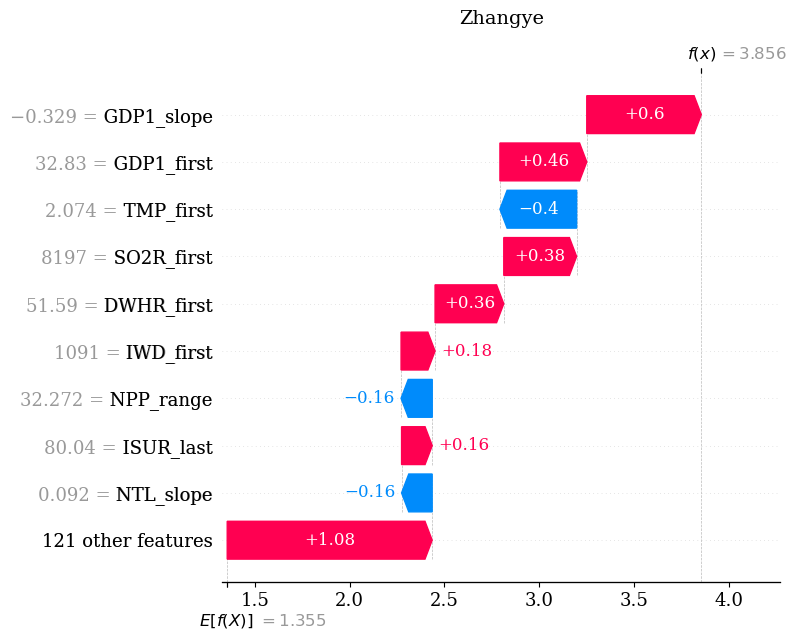

In [44]:
# 比如要看 Cluster 2 中 Citycode=130100 的 SHAP：张掖z
explain_city_with_waterfall(cluster_id=0, citycode=620700, topn=10,cityname="Zhangye")


城市 520300 | 实际簇 = 0 (输入簇 = 0)
GDP1_slope    0.667741
GDP1_first    0.425497
DWHR_first   -0.255875
TMP_first     0.172787
ISUR_mean    -0.170458
STE_last     -0.159525
NTL_slope    -0.156962
IWD_first     0.145137
GDP_curv2     0.143789
PUR_first     0.131439
dtype: float32
图片已保存为 waterfall_520300.png


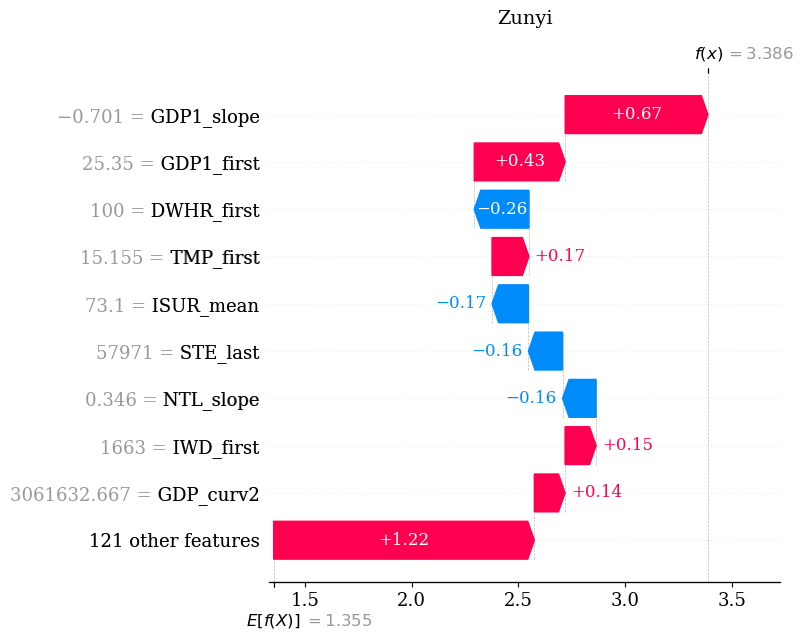

In [45]:
# 比如要看 Cluster 2 中 Citycode=130100 的 SHAP：遵义
explain_city_with_waterfall(cluster_id=0, citycode=520300, topn=10,cityname="Zunyi")


城市 310000 | 实际簇 = 1 (输入簇 = 1)
STE_curv2     0.776471
DWHR_curv2    0.394890
LST_curv2     0.353584
ISUR_vol1    -0.335315
CO2_vol1      0.328471
CO2_curv2     0.232834
SO2R_last    -0.220597
NTL_curv2     0.212949
GDP1_range    0.188627
IFE_first     0.180908
dtype: float32
图片已保存为 waterfall_310000.png


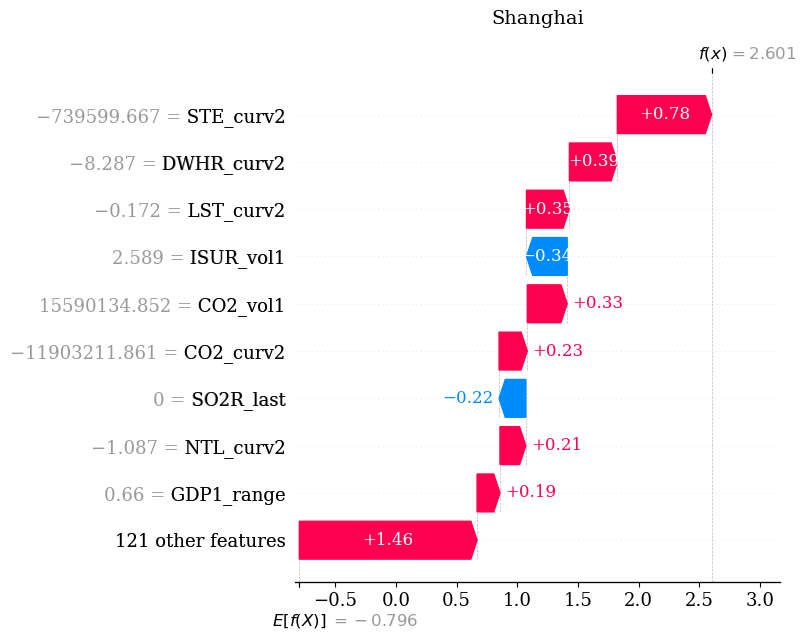

In [47]:
# 比如要看 Cluster 2 中 Citycode=130100 的 SHAP：上海s
explain_city_with_waterfall(cluster_id=1, citycode=310000, topn=10,cityname="Shanghai")


城市 500000 | 实际簇 = 1 (输入簇 = 1)
SO2R_last     1.051135
SO2R_curv2    0.490572
STE_curv2    -0.452474
DWHR_curv2    0.449225
LST_curv2    -0.308702
ISUR_vol1    -0.285596
CO2_vol1      0.275199
SO2R_range    0.185859
CO2_first     0.172009
ISUR_curv2    0.170341
dtype: float32
图片已保存为 waterfall_500000.png


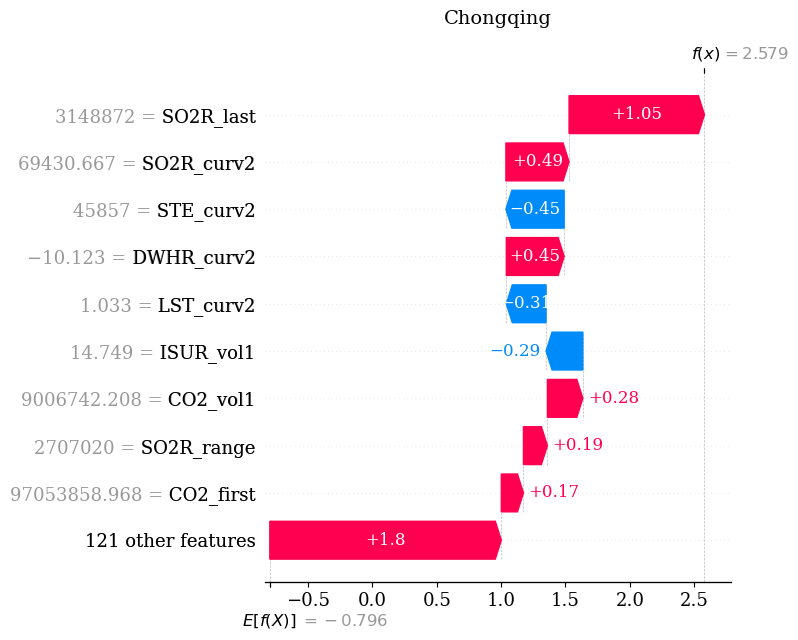

In [48]:
# 比如要看 Cluster 2 中 Citycode=130100 的 SHAP：重庆c
explain_city_with_waterfall(cluster_id=1, citycode=500000, topn=10,cityname="Chongqing")


城市 370800 | 实际簇 = 1 (输入簇 = 1)
SO2R_last     0.896500
STE_curv2     0.500482
DWHR_curv2    0.445538
LST_curv2     0.345456
CO2_vol1      0.286842
ISUR_vol1    -0.284921
PPC_curv2     0.183420
CO2_first     0.182922
IFE_first     0.182052
PPC_last      0.143580
dtype: float32
图片已保存为 waterfall_370800.png


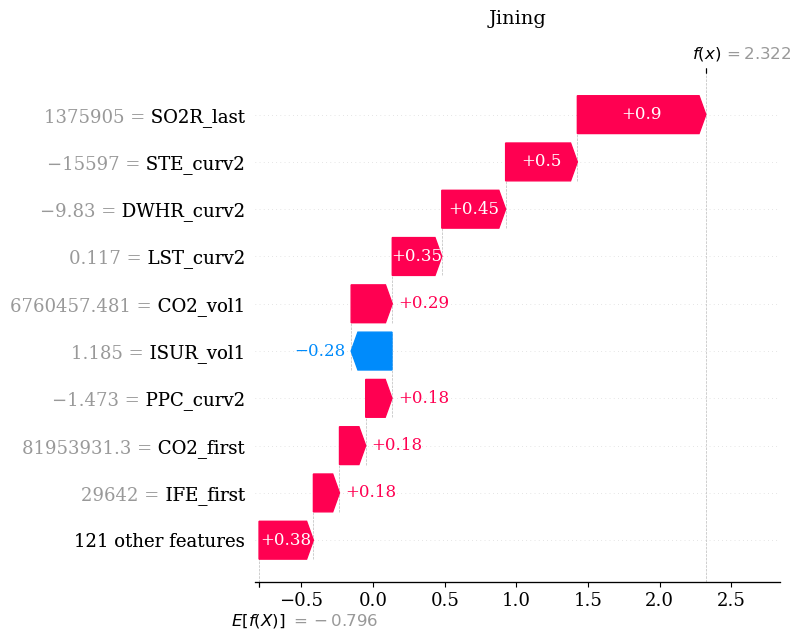

In [49]:
# 比如要看 Cluster 2 中 Citycode=130100 的 SHAP：济宁市
explain_city_with_waterfall(cluster_id=1, citycode=370800, topn=10,cityname="Jining")


城市 230100 | 实际簇 = 2 (输入簇 = 2)
DWHR_first    0.975569
DWHR_curv2    0.468513
PRE_first     0.364694
TMP_first     0.339482
SO2R_first   -0.237877
PUR_slope     0.205605
PUR_curv2     0.205548
PPC_slope     0.196743
PD_vol1       0.186482
PUR_first     0.183718
dtype: float32
图片已保存为 waterfall_230100.png


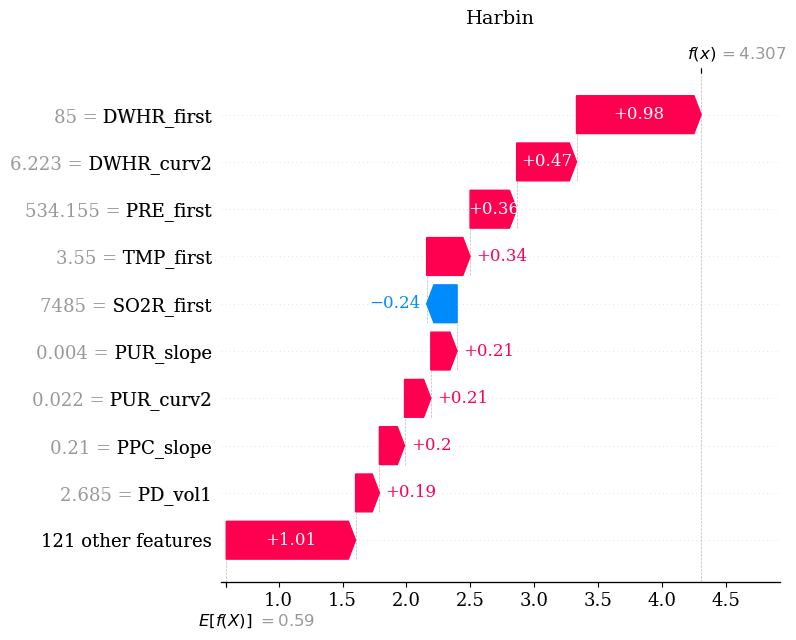

In [50]:
# 比如要看 Cluster 2 中 Citycode=130100 的 SHAP：哈尔滨
explain_city_with_waterfall(cluster_id=2, citycode=230100, topn=10,cityname="Harbin")


城市 370300 | 实际簇 = 2 (输入簇 = 2)
DWHR_first    0.901765
SO2R_first    0.830579
PRE_first     0.295869
DWHR_curv2    0.248691
TMP_first     0.232838
PPC_slope     0.200216
PD_vol1       0.195829
GDP_curv2     0.164930
PUR_first     0.156224
PPC_range     0.154759
dtype: float32
图片已保存为 waterfall_370300.png


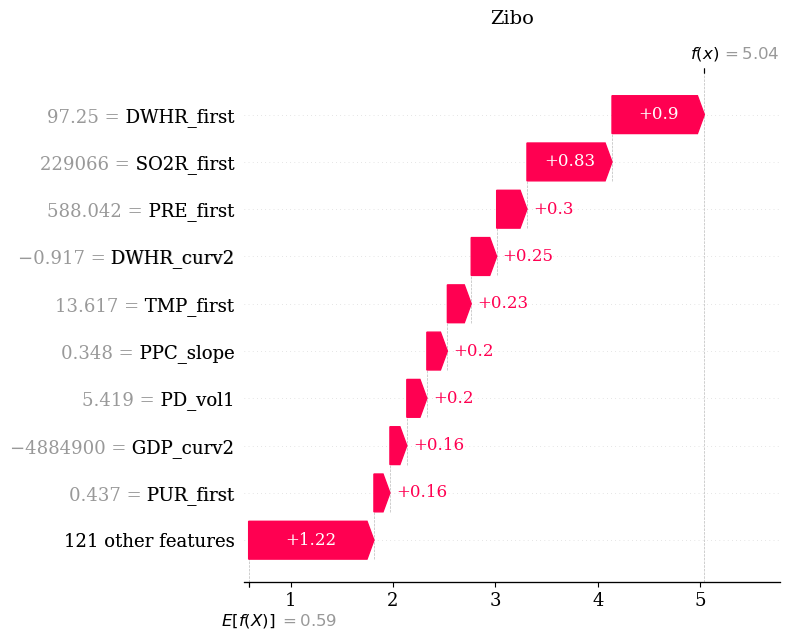

In [51]:
# 比如要看 Cluster 2 中 Citycode=130100 的 SHAP：淄博
explain_city_with_waterfall(cluster_id=2, citycode=370300, topn=10,cityname="Zibo")


城市 620100 | 实际簇 = 2 (输入簇 = 2)
PRE_first     0.316337
PUR_first     0.310297
TMP_first     0.298293
PPC_curv2     0.287609
SO2R_first   -0.250224
ISA_vol1      0.180418
PPC_range     0.169141
PD_vol1       0.140767
PUR_range     0.135471
GDP1_slope    0.134638
dtype: float32
图片已保存为 waterfall_620100.png


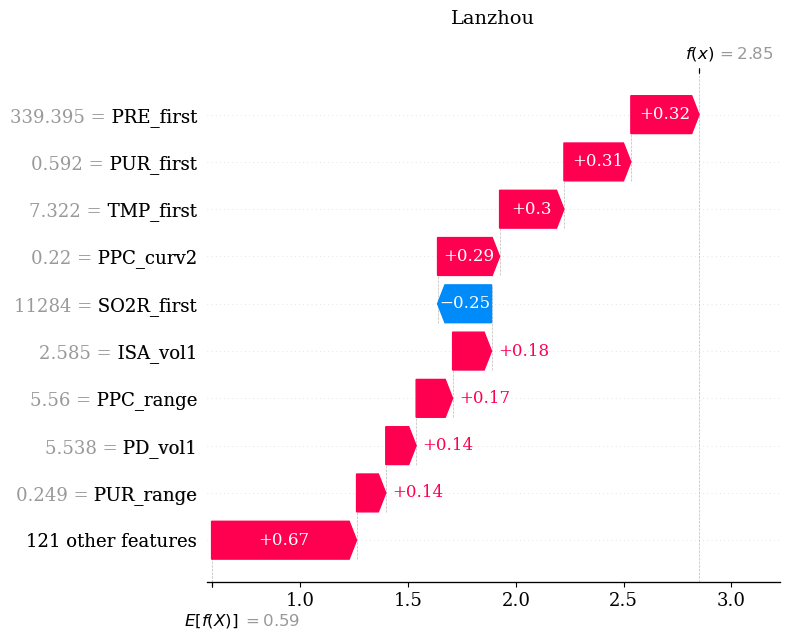

In [52]:
# 比如要看 Cluster 2 中 Citycode=130100 的 SHAP：兰州
explain_city_with_waterfall(cluster_id=2, citycode=620100, topn=10,cityname="Lanzhou")

In [34]:
# 分成“推向（正）/拉离（负）”两组

In [28]:
rows = []
for k in range(K):
    prof = cluster_profile(k)
    top_pos = prof.sort_values(ascending=False).head(10)
    top_neg = prof.sort_values().head(10)
    rows.append(pd.DataFrame({
        "cluster": k,
        "feature": top_pos.index,
        "mean_shap": top_pos.values,
        "direction": "push_to_k"
    }))
    rows.append(pd.DataFrame({
        "cluster": k,
        "feature": top_neg.index,
        "mean_shap": top_neg.values,
        "direction": "pull_from_k"
    }))
prof_table = pd.concat(rows, ignore_index=True)

In [29]:
prof_table

,cluster,feature,mean_shap,direction
0,0,Population_urbanization_curv2,0.594855,push_to_k
1,0,Rate_of_non_hazardous_treatment_of_domestic_wa...,0.340495,push_to_k
2,0,Parkland_per_capita_curv2,0.080484,push_to_k
3,0,Surface_Area_of_Built_District_slope,0.060798,push_to_k
4,0,Industrial_fume_emissions_(tonnes)_vol1,0.057003,push_to_k
5,0,First_sector_of_GDP_first,0.049918,push_to_k
6,0,Industrial_fume_emissions_(tonnes)_mean,0.039219,push_to_k
7,0,First_sector_of_GDP_curv2,0.033425,push_to_k
8,0,Rate_of_non_hazardous_treatment_of_domestic_wa...,0.031575,push_to_k
9,0,Population_urbanization_last,0.031189,push_to_k


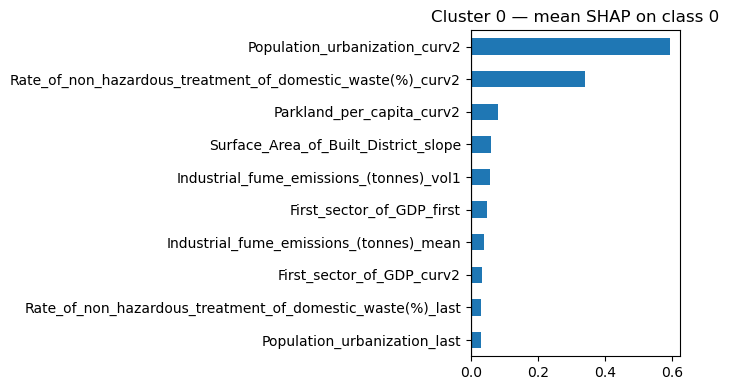

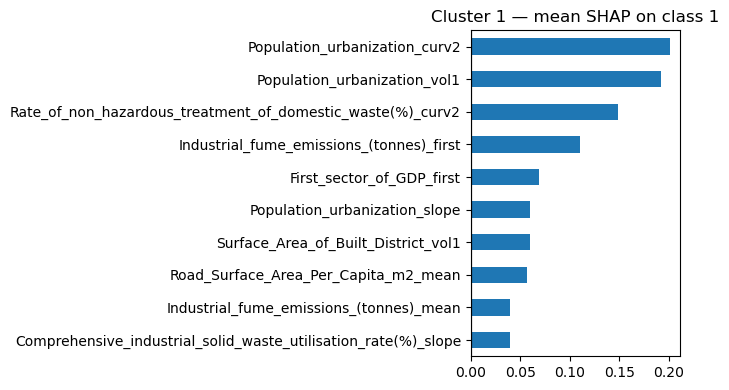

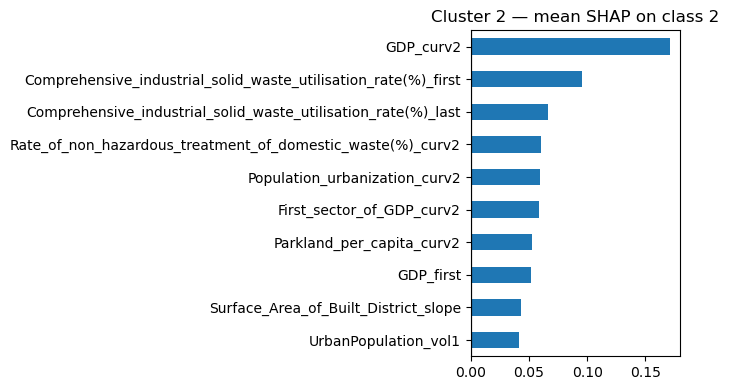

In [30]:
for k in range(K):
    prof = cluster_profile(k)
    top = prof.reindex(prof.abs().sort_values(ascending=False).head(10).index)
    plt.figure(figsize=(7,4))
    top.plot(kind="barh")
    plt.axvline(0, color="k", lw=0.8)
    plt.title(f"Cluster {k} — mean SHAP on class {k}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [35]:
# 簇与簇“对比解释”（为什么是 k 而不是 t）

In [31]:
def cluster_contrast(k, t):
    idx_k = np.where(y==k)[0]
    idx_t = np.where(y==t)[0]
    delta = shap_arr[idx_k,:,k].mean(axis=0) - shap_arr[idx_t,:,t].mean(axis=0)
    s = pd.Series(delta, index=X2.columns)
    return s

pairs = [(0,1),(0,2),(1,2)]
all_ct = []
for (k,t) in pairs:
    s = cluster_contrast(k,t)
    push = s.sort_values(ascending=False).head(10)  # 推向 k 的关键差异
    pull = s.sort_values().head(10)                 # 拉向 t 的关键差异
    print(f"\n=== Contrast: k={k} vs t={t} ===")
    print("\nPush to k (top+):\n", push)
    print("\nPull to t (top-):\n", pull)
    tmp = pd.concat([
        pd.DataFrame({"k":k,"t":t,"feature":push.index,"delta":push.values,"role":"push_to_k"}),
        pd.DataFrame({"k":k,"t":t,"feature":pull.index,"delta":pull.values,"role":"pull_to_t"})
    ])
    all_ct.append(tmp)

ct_table = pd.concat(all_ct, ignore_index=True)


=== Contrast: k=0 vs t=1 ===

Push to k (top+):
 Population_urbanization_curv2                                    0.393895
Rate_of_non_hazardous_treatment_of_domestic_waste(%)_curv2       0.192160
Parkland_per_capita_curv2                                        0.075168
Surface_Area_of_Built_District_slope                             0.057346
Industrial_fume_emissions_(tonnes)_vol1                          0.034301
First_sector_of_GDP_curv2                                        0.026049
Population_urbanization_last                                     0.022602
UrbanPopulation_slope                                            0.021528
Comprehensive_industrial_solid_waste_utilisation_rate(%)_last    0.020839
UrbanPopulation_first                                            0.019088
dtype: float32

Pull to t (top-):
 Population_urbanization_vol1                                     -0.177561
Industrial_fume_emissions_(tonnes)_first                         -0.104090
Population_urbanization_s

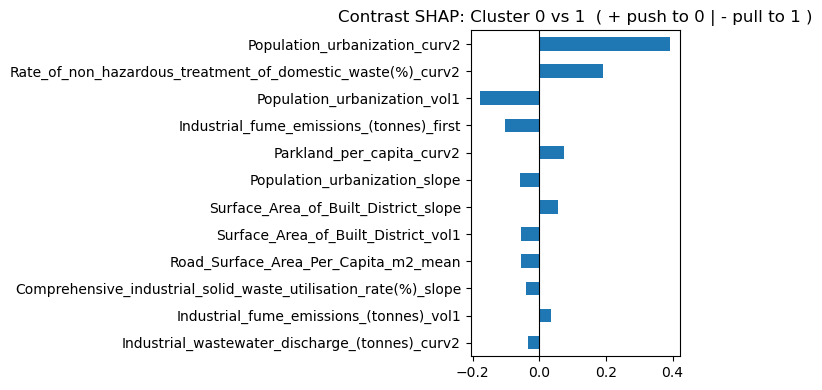

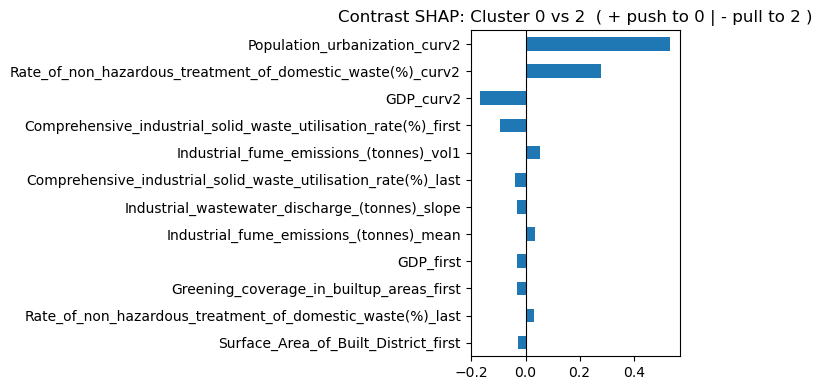

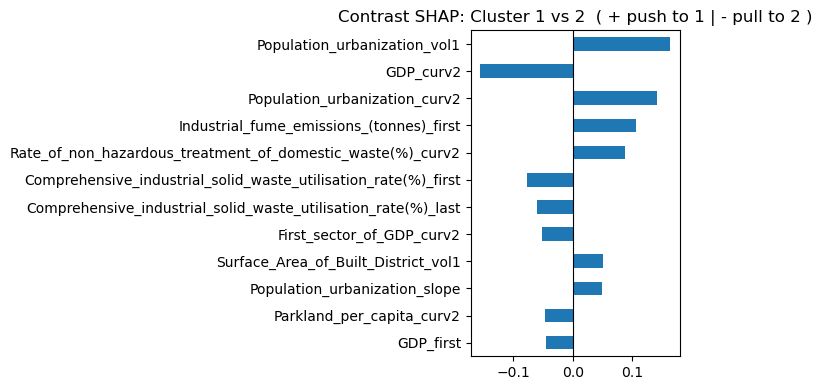

In [32]:
for (k,t) in pairs:
    s = cluster_contrast(k,t)
    top = s.reindex(s.abs().sort_values(ascending=False).head(12).index)
    plt.figure(figsize=(7,4))
    top.plot(kind="barh")
    plt.axvline(0, color="k", lw=0.8)
    plt.title(f"Contrast SHAP: Cluster {k} vs {t}  ( + push to {k} | - pull to {t} )")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()